# Weather dataset drift localisation with different classifiers - montly predictions

In [1]:
import numpy as np
import pandas as pd
from scipy.io import arff
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import math

from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)


from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

## Accept and preprocess the weather dataset

In [2]:
df = pd.read_csv("real_world_data/weather_dataset.csv")

print(df.head())

X = df.drop(columns=['Unnamed: 0', 'Label_Rain'])
y = df["Label_Rain"]

print(X.head())
print(y.head())

X_ref = X[:6053]
X_test = X[6053:]
y_ref = y[:6053]
y_test = y[6053:]

# X_ref, X_test, y_ref, y_test = train_test_split(X, y, train_size=0.30, shuffle=False)

X_ref = X_ref.to_numpy()
X_test = X_test.to_numpy()
y_ref = y_ref.to_numpy()
y_test = y_test.to_numpy()

# scale the data - consistency measure: it will also be scaled for drift detection later
scaler = MinMaxScaler()
scaler.fit(X_ref)
X_ref = scaler.transform(X_ref)
X_test = scaler.transform(X_test)

print('\nreference data')
print(X_ref.shape)
print(X_ref)
print('\nreference labels')
print(y_ref.shape)
print('\ntesting data')
print(X_test.shape)
print(X_test)
print('\ntesting labels')
print(y_test.shape)

   Unnamed: 0  TEMP  DEWP     SLP  VISIB  WDSP  MXSPD   MAX   MIN  Label_Rain
0           0  24.7  21.3  1013.8    1.8   8.9   12.0  30.9  19.9           1
1           1  26.6  20.1  1015.7    5.5  11.9   18.1  30.0  19.0           1
2           2  24.0  16.5  1018.6    9.3   8.0   14.0  28.9  19.0           0
3           3  24.9  17.2  1014.2   10.6   6.7   22.0  39.9  17.1           0
4           4  21.9  12.3  1017.5    9.8  10.5   28.9  34.0  15.1           0
   TEMP  DEWP     SLP  VISIB  WDSP  MXSPD   MAX   MIN
0  24.7  21.3  1013.8    1.8   8.9   12.0  30.9  19.9
1  26.6  20.1  1015.7    5.5  11.9   18.1  30.0  19.0
2  24.0  16.5  1018.6    9.3   8.0   14.0  28.9  19.0
3  24.9  17.2  1014.2   10.6   6.7   22.0  39.9  17.1
4  21.9  12.3  1017.5    9.8  10.5   28.9  34.0  15.1
0    1
1    1
2    0
3    0
4    0
Name: Label_Rain, dtype: int64

reference data
(6053, 8)
[[0.32335329 0.45853659 0.50909091 ... 0.21443737 0.00335913 0.36567926]
 [0.34231537 0.44682927 0.53787879 ... 0.34

## Define helper functions

In [3]:
import random


def take_out_random_batch(X, y, batch_size, random_state):
    """Take a random batch of data out of the reference data"""
    random.seed(a=random_state)
    start = random.randint(0, X.shape[0] - batch_size)
    indices = list(range(start, start + batch_size))
    
    X_extracted_batch = X[indices]
    X_rest = np.delete(X, indices, axis=0)
    y_extracted_batch = y[indices]
    y_rest = np.delete(y, indices, axis=0)
    
#     print('shape of points in the extracted batch')
#     print(X_extracted_batch.shape)
#     print('shape of points in the rest')
#     print(X_rest.shape)
    
    return X_extracted_batch, X_rest, y_extracted_batch, y_rest


def find_model_expected_accuracy(X, y, batch_size, model, min_runs=10, std_err_threshold=0.05):
    print('model', model)
    accuracies = []
    accuracy_std_err = 100
    current_random_state = 0
    i = 0
    while i < min_runs or accuracy_std_err > std_err_threshold:
        X_extracted_batch, X_rest, y_extracted_batch, y_rest = take_out_random_batch(
            X_ref, y_ref, batch_size, random_state=current_random_state)
        y_pred = model.fit(X_rest, y_rest).predict(X_extracted_batch)
        accuracies.append(accuracy_score(y_extracted_batch, y_pred))
        if len(accuracies) > 1:
            accuracy_std_err = np.std(accuracies) / np.sqrt(len(accuracies))
        current_random_state += 1
        i += 1
    
    return np.mean(accuracies), np.std(accuracies)

## Define parameter values

In [4]:
random_state = 42
batch_size = 30  # monthly predictions

## Find the model with the highest accuracy

In [7]:
model_names = ["GaussianNB", "DecisionTreeClassifier", "KNeighborsClassifier", "SVM", "LogisticRegression"]
model_final_accuracies = {
    "GaussianNB": 0.0,
    "DecisionTreeClassifier": 0.0,
    "KNeighborsClassifier": 0.0,
    "SVM": 0.0,
    "LogisticRegression": 0.0
}

### Try GaussianNB

In [7]:
gnb = GaussianNB()

model_final_accuracies["GaussianNB"], _ = find_model_expected_accuracy(X_ref, y_ref, batch_size, model=gnb)

model GaussianNB()


### Hyperparameter tuning imports

In [8]:
import skopt
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

### Try decision trees

model DecisionTreeClassifier(max_depth=78, random_state=42)
model DecisionTreeClassifier(max_depth=11, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=42)
model DecisionTreeClassifier(max_depth=72, random_state=42)
model DecisionTreeClassifier(max_depth=99, random_state=42)
model DecisionTreeClassifier(max_depth=2, random_state=42, splitter='random')
model DecisionTreeClassifier(criterion='entropy', max_depth=41, random_state=42,
                       splitter='random')
model DecisionTreeClassifier(criterion='entropy', max_depth=24, random_state=42,
                       splitter='random')
model DecisionTreeClassifier(criterion='entropy', max_depth=39, random_state=42,
                       splitter='random')
model DecisionTreeClassifier(max_depth=86, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=49, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=100, random_state=42)
model Dec

C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=24, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=23, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=28, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=22, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=22, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=22, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=100, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=71, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=85, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=25, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=42, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=100, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=65, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=91, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=52, random_state=42)
model DecisionTreeClassifier(max_depth=38, random_state=42, splitter='random')


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=86, random_state=42,
                       splitter='random')


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=78, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=36, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)
model DecisionTreeClassifier(max_depth=16, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(max_depth=100, random_state=42, splitter='random')


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=57, random_state=42,
                       splitter='random')


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)
model DecisionTreeClassifier(max_depth=79, random_state=42, splitter='random')


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=12, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=19, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42)
model DecisionTreeClassifier(max_depth=22, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=68, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=46, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=93, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)
model DecisionTreeClassifier(max_depth=44, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=39, random_state=42)
model DecisionTreeClassifier(max_depth=64, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=21, random_state=42)
Best accuracy=0.7500
Best parameters: ['entropy', 'best', 22]


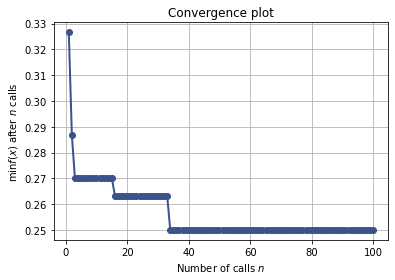

In [9]:
model = DecisionTreeClassifier(random_state=random_state) # best accuracy = 0.7500

space  = [Categorical(['gini', 'entropy'], name='criterion'), # best = 'entropy'
         Categorical(['best', 'random'], name='splitter'), # best = 'best'
         Integer(1, 100, name='max_depth')] # best = 22

@use_named_args(space)
def objective(**params):
    model.set_params(**params)
    return (1 - (find_model_expected_accuracy(X_ref, y_ref, batch_size, model=model))[0])

res_gp = gp_minimize(objective, space, n_calls=100, random_state=random_state)

print("Best accuracy=%.4f" % (1 - res_gp.fun))
print("""Best parameters:""", res_gp.x)
plot_convergence(res_gp)
model_final_accuracies["DecisionTreeClassifier"] = (1 - res_gp.fun)

### Try k nearest neighbors

model KNeighborsClassifier(n_neighbors=160)
model KNeighborsClassifier(n_neighbors=38)
model KNeighborsClassifier(n_neighbors=156)
model KNeighborsClassifier(n_neighbors=120)
model KNeighborsClassifier(n_neighbors=90)
model KNeighborsClassifier(n_neighbors=21)
model KNeighborsClassifier(n_neighbors=92)
model KNeighborsClassifier(n_neighbors=67)
model KNeighborsClassifier(n_neighbors=29)
model KNeighborsClassifier(n_neighbors=131)
model KNeighborsClassifier(n_neighbors=200)
model KNeighborsClassifier(n_neighbors=172)
model KNeighborsClassifier(n_neighbors=147)
model KNeighborsClassifier(n_neighbors=112)
model KNeighborsClassifier(n_neighbors=153)
model KNeighborsClassifier(n_neighbors=1)
model KNeighborsClassifier(n_neighbors=79)
model KNeighborsClassifier(n_neighbors=186)
model KNeighborsClassifier(n_neighbors=55)
model KNeighborsClassifier(n_neighbors=82)
model KNeighborsClassifier(n_neighbors=163)
model KNeighborsClassifier(n_neighbors=77)
model KNeighborsClassifier(n_neighbors=144)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=148)
model KNeighborsClassifier(n_neighbors=132)
model KNeighborsClassifier(n_neighbors=105)
model KNeighborsClassifier(n_neighbors=150)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=150)
model KNeighborsClassifier(n_neighbors=151)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=200)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=148)
model KNeighborsClassifier(n_neighbors=141)
model KNeighborsClassifier(n_neighbors=124)
model KNeighborsClassifier(n_neighbors=86)
model KNeighborsClassifier(n_neighbors=101)
model KNeighborsClassifier(n_neighbors=61)
model KNeighborsClassifier(n_neighbors=48)
model KNeighborsClassifier(n_neighbors=178)
model KNeighborsClassifier(n_neighbors=12)
model KNeighborsClassifier(n_neighbors=157)
model KNeighborsClassifier(n_neighbors=71)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=163)
model KNeighborsClassifier(n_neighbors=193)
model KNeighborsClassifier(n_neighbors=168)
model KNeighborsClassifier(n_neighbors=154)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=124)
model KNeighborsClassifier(n_neighbors=117)
model KNeighborsClassifier(n_neighbors=127)
model KNeighborsClassifier(n_neighbors=108)
model KNeighborsClassifier(n_neighbors=64)
model KNeighborsClassifier(n_neighbors=58)
model KNeighborsClassifier(n_neighbors=135)
model KNeighborsClassifier(n_neighbors=97)
model KNeighborsClassifier(n_neighbors=43)
model KNeighborsClassifier(n_neighbors=182)
model KNeighborsClassifier(n_neighbors=196)
model KNeighborsClassifier(n_neighbors=175)
model KNeighborsClassifier(n_neighbors=190)
model KNeighborsClassifier(n_neighbors=72)
model KNeighborsClassifier(n_neighbors=149)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=137)
model KNeighborsClassifier(n_neighbors=138)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=137)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=147)
model KNeighborsClassifier(n_neighbors=74)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=147)
model KNeighborsClassifier(n_neighbors=161)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=127)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=160)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=58)
model KNeighborsClassifier(n_neighbors=122)
model KNeighborsClassifier(n_neighbors=88)
model KNeighborsClassifier(n_neighbors=80)
model KNeighborsClassifier(n_neighbors=84)
model KNeighborsClassifier(n_neighbors=165)
model KNeighborsClassifier(n_neighbors=129)
model KNeighborsClassifier(n_neighbors=7)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=157)
model KNeighborsClassifier(n_neighbors=57)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=156)
model KNeighborsClassifier(n_neighbors=59)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=131)
model KNeighborsClassifier(n_neighbors=140)
model KNeighborsClassifier(n_neighbors=159)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=154)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=154)
model KNeighborsClassifier(n_neighbors=52)
model KNeighborsClassifier(n_neighbors=62)
model KNeighborsClassifier(n_neighbors=142)
model KNeighborsClassifier(n_neighbors=119)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=153)
model KNeighborsClassifier(n_neighbors=170)
model KNeighborsClassifier(n_neighbors=81)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=81)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=81)
model KNeighborsClassifier(n_neighbors=33)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=81)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model KNeighborsClassifier(n_neighbors=81)
Best accuracy=0.7667
Best parameters: [81]


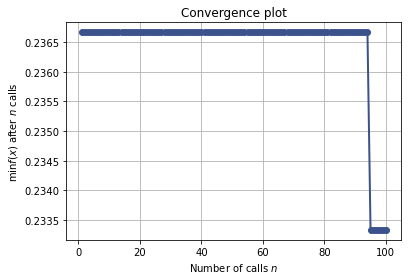

In [14]:
model = KNeighborsClassifier() # best accuracy = 0.7667

space  = [Integer(1, 100, name='n_neighbors')] # best = 81

@use_named_args(space)
def objective(**params):
    model.set_params(**params)
    return (1 - (find_model_expected_accuracy(X_ref, y_ref, batch_size, model=model))[0])

res_gp = gp_minimize(objective, space, n_calls=100, random_state=random_state)

print("Best accuracy=%.4f" % (1 - res_gp.fun))
print("""Best parameters:""", res_gp.x)
plot_convergence(res_gp)
model_final_accuracies["KNeighborsClassifier"] = (1 - res_gp.fun)

### Try SVM

model SVC(C=15.951205438518636, random_state=42)
model SVC(C=3.75035231833666, random_state=42)
model SVC(C=15.615850905428111, random_state=42)
model SVC(C=11.977318143135092, random_state=42)
model SVC(C=8.972071781786465, random_state=42)
model SVC(C=2.089500824778258, random_state=42)
model SVC(C=9.239052950120758, random_state=42)
model SVC(C=6.740801361666535, random_state=42)
model SVC(C=2.943049676646622, random_state=42)
model SVC(C=13.052680611682174, random_state=42)
Best accuracy=0.7667
Best parameters: [2.089500824778258]


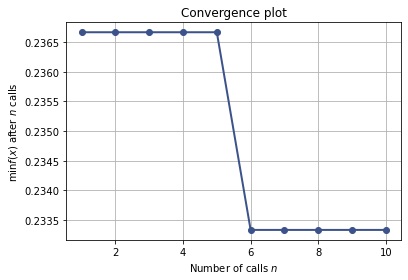

In [11]:
model = SVC(random_state=random_state) # best accuracy = 0.7667

space  = [Real(0.1, 20, name='C')] # best = 2.09

@use_named_args(space)
def objective(**params):
    model.set_params(**params)
    return (1 - (find_model_expected_accuracy(X_ref, y_ref, batch_size, model=model))[0])

res_gp = gp_minimize(objective, space, n_calls=10, random_state=random_state)

print("Best accuracy=%.4f" % (1 - res_gp.fun))
print("""Best parameters:""", res_gp.x)
plot_convergence(res_gp)
model_final_accuracies["SVM"] = (1 - res_gp.fun)

### Try logistic regression

model LogisticRegression(C=15.951205438518636, max_iter=10000, random_state=42)
model LogisticRegression(C=3.75035231833666, max_iter=10000, random_state=42)
model LogisticRegression(C=15.615850905428111, max_iter=10000, random_state=42)
model LogisticRegression(C=11.977318143135092, max_iter=10000, random_state=42)
model LogisticRegression(C=8.972071781786465, max_iter=10000, random_state=42)
model LogisticRegression(C=2.089500824778258, max_iter=10000, random_state=42)
model LogisticRegression(C=9.239052950120758, max_iter=10000, random_state=42)
model LogisticRegression(C=6.740801361666535, max_iter=10000, random_state=42)
model LogisticRegression(C=2.943049676646622, max_iter=10000, random_state=42)
model LogisticRegression(C=13.052680611682174, max_iter=10000, random_state=42)
model LogisticRegression(C=19.996999965279368, max_iter=10000, random_state=42)
model LogisticRegression(C=18.117588650682713, max_iter=10000, random_state=42)
model LogisticRegression(C=10.397441710451778, 

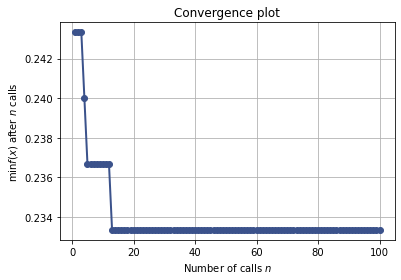

In [12]:
model = LogisticRegression(random_state=random_state, max_iter=10000) # best accuracy = 0.7667

space  = [Real(0.1, 20, name='C')] # best = 10.40

@use_named_args(space)
def objective(**params):
    model.set_params(**params)
    return (1 - (find_model_expected_accuracy(X_ref, y_ref, batch_size, model=model))[0])

res_gp = gp_minimize(objective, space, n_calls=100, random_state=random_state)

print("Best accuracy=%.4f" % (1 - res_gp.fun))
print("""Best parameters:""", res_gp.x)
plot_convergence(res_gp)
model_final_accuracies["LogisticRegression"] = (1 - res_gp.fun)

## Use the best model to define drifting batches

### Find the best model through accuracies

In [5]:
print('best obtained model accuracies:')
print(model_final_accuracies)

best obtained model accuracies:


NameError: name 'model_final_accuracies' is not defined

### Define the model with the best parameters (hardcoded in the cells above), get its accuracy information

In [6]:
# taking SVM because it performs best in yearly predictions

best_model = SVC(random_state=random_state, C=2.09)
expected_accuracy, expected_standard_deviation = find_model_expected_accuracy(X_ref, y_ref, batch_size, model=best_model)
print('expected accuracy:', expected_accuracy)
print('expected standard deviation:', expected_standard_deviation)

model SVC(C=2.09, random_state=42)
expected accuracy: 0.7666666666666667
expected standard deviation: 0.06992058987801013


### Fit the model on all reference data

In [7]:
best_model_fitted = SVC(random_state=random_state, C=2.09).fit(X_ref, y_ref)

### Split testing data to batches

In [8]:
def split_to_fixed_size_batches(X, y, batch_size):
    """Split X and y to batches of the given batch_size"""
    chunk_size = batch_size
    print('chunk size', chunk_size)

    num_chunks = (X.shape[0] - (X.shape[0] % chunk_size)) // chunk_size
    print('number of chunks', num_chunks)
    print('number of data', X.shape[0])
    X_perfect_size = X[:-(X.shape[0] % chunk_size), :]
    y_perfect_size = y[:-(y.shape[0] % chunk_size)]
    print('shape of X that can be split perfectly', X_perfect_size.shape)
    X_batches = np.array_split(X_perfect_size, num_chunks)
    y_batches = np.array_split(y_perfect_size, num_chunks)

    print('number of resulting batches', len(X_batches))
    print(X_batches[0])
    print(X_batches[0].shape)
    
    return X_batches, y_batches


X_test_batches, y_test_batches = split_to_fixed_size_batches(X_test, y_test, batch_size=batch_size)

chunk size 30
number of chunks 403
number of data 12106
shape of X that can be split perfectly (12090, 8)
number of resulting batches 403
[[0.80538922 0.84       0.57272727 0.63404255 0.14285714 0.16985138
  0.00855777 0.7854954 ]
 [0.82035928 0.85853659 0.56060606 0.65106383 0.11278195 0.14861996
  0.00936756 0.7854954 ]
 [0.88922156 0.87804878 0.49242424 0.62978723 0.16165414 0.1910828
  0.00965749 0.86823289]
 [0.8992016  0.92682927 0.4530303  0.6212766  0.21052632 0.23142251
  0.00987743 0.87742594]
 [0.94111776 0.94829268 0.42272727 0.62978723 0.2556391  0.21019108
  0.01026733 0.92849847]
 [0.93013972 0.95219512 0.44090909 0.62978723 0.22180451 0.16985138
  0.00987743 0.94892748]
 [0.85129741 0.96878049 0.53181818 0.65957447 0.15413534 0.25690021
  0.00926759 0.8886619 ]
 [0.84431138 0.96585366 0.57878788 0.50638298 0.16541353 0.10828025
  0.0084678  0.8886619 ]
 [0.84231537 0.95317073 0.57575758 0.22978723 0.12030075 0.08280255
  0.00866775 0.89785495]
 [0.84231537 0.89170732 0.

### Find test batch accuracies

In [9]:
accs = []
for batch in range(len(X_test_batches)):
    accs.append(accuracy_score(y_test_batches[batch], best_model.predict(X_test_batches[batch])))
    
print('\nTEST BATCH ACCURACIES')
print(accs)


TEST BATCH ACCURACIES
[0.9, 0.8333333333333334, 0.7, 0.8666666666666667, 0.8333333333333334, 0.7333333333333333, 0.9, 0.8, 0.8, 0.7333333333333333, 0.6666666666666666, 0.6666666666666666, 0.7333333333333333, 0.6666666666666666, 0.9666666666666667, 0.8, 0.7, 0.43333333333333335, 0.7333333333333333, 0.8333333333333334, 0.8666666666666667, 0.7333333333333333, 0.9, 0.7666666666666667, 0.8, 0.7666666666666667, 0.7666666666666667, 0.6666666666666666, 0.7, 0.8, 0.6333333333333333, 0.8, 0.7666666666666667, 0.8, 0.6666666666666666, 0.8, 0.7666666666666667, 0.8333333333333334, 0.8, 0.7666666666666667, 0.8666666666666667, 0.7666666666666667, 0.6666666666666666, 0.8333333333333334, 0.7, 0.7333333333333333, 0.6666666666666666, 0.6333333333333333, 0.6333333333333333, 0.7333333333333333, 0.8, 0.9666666666666667, 0.8333333333333334, 0.8666666666666667, 0.8, 0.8333333333333334, 0.8333333333333334, 0.7666666666666667, 0.7, 0.8333333333333334, 0.7666666666666667, 0.7333333333333333, 0.7333333333333333, 

### Show drifting batches visually (below red line = drift)

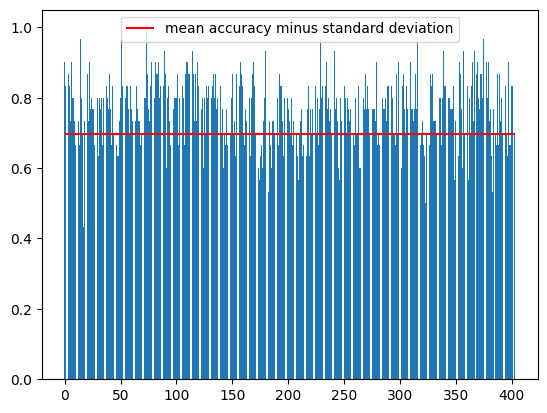

In [10]:
total_num_batches = len(X_test_batches)
barlist = plt.bar(range(total_num_batches), accs)
plt.hlines(y=expected_accuracy - expected_standard_deviation, xmin=0, xmax=total_num_batches,
           color='r', label='mean accuracy minus standard deviation')
plt.legend(loc='upper center')
plt.show()

### Define drifting batches

In [11]:
# define the batches with and without drift (same as the plot above)

drift_boolean_mask = [True if acc < expected_accuracy - expected_standard_deviation else False for acc in accs]
print('Drift in first 100 batches:')
print(drift_boolean_mask[:100])

Drift in first 100 batches:
[False, False, False, False, False, False, False, False, False, False, True, True, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, False, True, False, False, False, False, False, False, False, True, False, False, False, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False]


### Store the result in a file

In [12]:
import csv
with open('weather_monthly_drifts.csv', 'w') as f:
    wrtr = csv.writer(f)
    wrtr.writerow(drift_boolean_mask)